<a href="https://colab.research.google.com/github/MaschinenNah/FramePredictionProject/blob/main/frame_predictor_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Package ml_utils laden und importieren

In [ ]:
!git clone https://github.com/MaschinenNah/ml_utils
from ml_utils import load
from ml_utils import show
from ml_utils import frame_predict as fp

Cloning into 'ml_utils'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 121 (delta 56), reused 85 (delta 27), pack-reused 0
Receiving objects: 100% (121/121), 14.38 KiB | 4.79 MiB/s, done.
Resolving deltas: 100% (56/56), done.


### Daten laden

In [ ]:
zip_url = "http://pitnoack.de/mn/frame_pred_proc_zufaellige_formen/data.zip"
load.load_and_unzip_from_url(zip_url)

### Generator initialisieren

In [ ]:
gen = fp.FramePredictionGenerator("/content/data/scenes", (48, 48), 8, 50)

### Generator visuell prüfen

x (50, 8, 48, 48)
y (50, 48, 48)


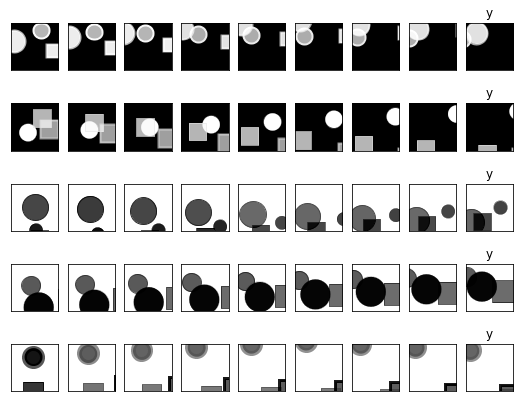

In [ ]:
batch = gen[0]

print("x", batch[0].shape)
print("y", batch[1].shape)
show.show_frame_prediction_batch(batch, 5)

### GPU starten
(ist für den test der loss funktion irrelevant, denke ich...)

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu May  6 14:10:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    33W / 250W |    863MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Modell entwerfen

In [ ]:
import numpy as np

from keras.layers import Input, Flatten, Dense, Reshape, LeakyReLU, Dropout, Conv3D, MaxPool3D, Conv3DTranspose
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.datasets import mnist

input_shape = (8, 48, 48)
output_shape = (48, 48)

input_layer = Input(shape=input_shape)

x = Flatten()(input_layer)

x = Dropout(0.2)(x)

x = Dense(1000, activation="sigmoid")(x)

x = Dropout(0.2)(x)

x = Dense(1000, activation="sigmoid")(x)

x = Dropout(0.2)(x)

x = Dense(2304, activation="sigmoid")(x)

output_layer = Reshape(output_shape)(x)

model = Model(input_layer, output_layer)

model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 8, 48, 48)]       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 18432)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1000)              18433000  
_________________________________________________________________
dropout_7 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dropout_8 (Dropout)          (None, 1000)              0   

### Optimierer setzen und Modell kompilieren

In [ ]:
from scipy import ndimage
import tensorflow as tf


def blurriness(img_as_np_array):  
  return 1.0 / ndimage.laplace(img_as_np_array).var()

optimizer = Adam(lr=0.0005)


def loss(y_true, y_pred):
  #y_pred ist ein symbolischer Tensor,
  # die blurriness-Funktion erwartet aber ein Numpy Array
  blurriness = blurriness( )
  equality = K.mean(K.square(y_true - y_pred), axis = [1,2])
  return equality + blurriness

model.compile(loss=loss, optimizer=optimizer)

### Modell trainieren

In [ ]:
model.fit(gen, epochs=10)

Epoch 1/10


NotImplementedError: ignored

### Predictions ansehen

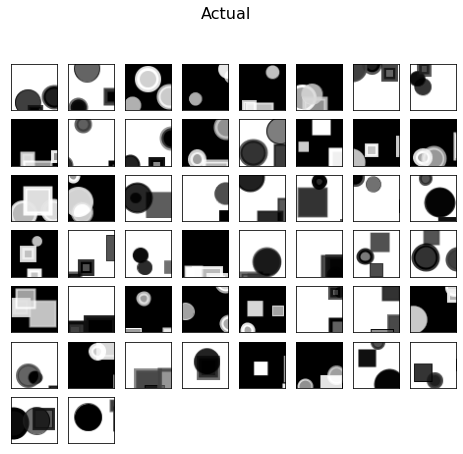

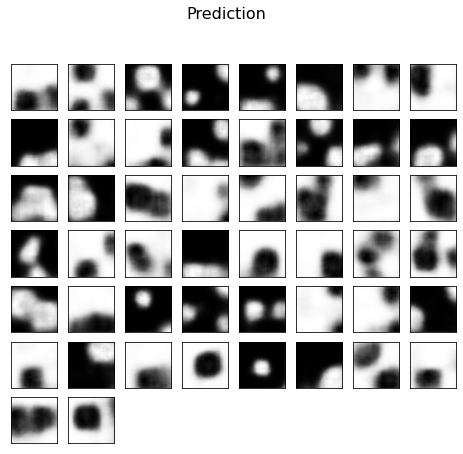

In [ ]:
x = gen[0][0]
y = gen[0][1]
y_pred = model.predict(x)
show.show_images_from_np_array(y, "Actual")
show.show_images_from_np_array(y_pred, "Prediction")

### Hilfsfunktionen für Rückkopplung

In [ ]:
def predict_single(model, input):
  input = input[np.newaxis, ...]
  output = model.predict(input)[0]
  return output

def dream_step(model, input):
  predicted_image = predict_single(model, input)
  
  output = np.empty_like(input)
  output[:-1] = input[1:]
  output[-1] = predicted_image
  return output

### Film träumen

In [ ]:
from cv2 import VideoWriter
import cv2
from matplotlib import pyplot as plt

# Abmessungen und Bildrate:
width, height = 48, 48
frame_rate = 10

# Der Codec. Mit diesem hier haben wir gute Erfahrungen gemacht:
codec = cv2.VideoWriter_fourcc(*'mp4v')

# So initialisieren wir den VideoWriter.
# Das erste Argument bestimmt den Pfad zur Ausgabedatei.
# Achtung: Die Abmessungen werden hier in der üblichen Reihenfolge geschrieben,
# also (Breite, Höhe) - also nicht so, wie wir es von NumPy Arrays gewohnt sind.
out = VideoWriter('film.mp4', codec, frame_rate, (width, height))

input = gen[0][0][4]


for _ in range(1000):
  img = input[-1]
  plt.imshow(img, cmap='gray')
  plt.show()
  input = dream_step(model, input)
  img8bit = (img * 255.0).astype("uint8")
  img8bit = np.stack((img8bit,)*3, axis=-1)
  black_image = np.zeros((height, width, 3), "uint8")
  out.write(img8bit)
  
out.release()
cv2.destroyAllWindows()

### Versuche zur Unschärfe

In [ ]:
from scipy import ndimage

def single_blurriness(img_as_np_array):  
  return 1.0 / ndimage.laplace(img_as_np_array).var()

def batch_blurriness(y_pred, factor=0.0001):
  result = 0;
  n_images = y_pred.shape[0]
  for i in range(n_images):
    blurriness = single_blurriness(y_pred[i])
    result = result + blurriness
  return result * factor

batch_blurriness(y_pred)

12.99995706480626